In [1]:
import gensim
import subprocess
import re
import numpy as np
import time
import nltk
import os
import json
import collections
import time
import matplotlib.pyplot as plt
import itertools
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
nltk.download('stopwords')
nltk.download('punkt')

Using TensorFlow backend.
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/fra

True

### Problema: Determinar la veracidad de tweets, utilizando clasificación
- Implementar un clasificador de post de tweets para validar su veracidad.
- Para esto se utilizará redes neuronales y el árbol de  propagación de los tweets.


In [2]:
#Image("/home/eprovidel/Text_Mining/Proyecto/modelos.png")

In [3]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

# Parte 1: Procesamiento de datos y funcionalidades

## Parte 1.1: Cargar tweets para generar datos de entrenamiento

In [4]:
words_not_in_model = list()
def computeDocumentAWE(docText, _model, _model_vocab, _emb_size):
    """
    Calcula el AWE del texto recibido en el parámetro docText.
    La variable docSum almacena la suma de los embeddings de cada
    palabra w en docText. Luego esta suma se divide por el total
    de n palabras consideradas.
    
    Se considero una palabra para el cálculo sólo si esta pertenece
    al vocabulario del modelo. Si no, no es considerada en la suma 
    ni tampoco en el calculo de n.
    """    
    docSum = np.zeros(_emb_size)
    n = 0
    
    ####
    ## AWE = 1/n * Sum w_embedding, para cada w en docText
    ####
    
    normalizedDocText = normalizarTexto(docText)
    
    for w in normalizedDocText:
        ## Se descartan palabras que no están en el modelo de embeddings (vocabulario)
        if w in _model_vocab:
            n = n + 1
            w_embedding = _model[w]
            docSum = docSum + w_embedding
        else:
            words_not_in_model.append(w)

    return docSum / n if n > 0 else docSum    

In [5]:
def normalizarTexto(docText):
    # En gensim.utils, pasa a minúsculas, descarta palabras muy grandes o muy pequeñas.
    return simple_preprocess(docText)

In [6]:
def parseTwitterTree(tree_file):
    tree_data = list()
    for line in tree_file:
        _, second_part = line.split('->')
        second_part = second_part.rstrip()
        second_part = second_part.replace("'", "\"")
        tree_data.append(json.loads(second_part))     
    return tree_data

In [7]:
def moses():
    p = subprocess.Popen("/home/kirov/dataset/script.sh", stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stderr = p.communicate()
    p.wait()   

In [9]:
### Obtener diccionario con todos los posts
all_posts = {}
all_text = {}
for file in os.listdir('/home/kirov/dataset/post'):
    if file.endswith(".json"):        
        try:        
            with open(os.path.join('/home/kirov/dataset/post', file), 'r') as f:
                tweet_id  = os.path.splitext(file)[0]
                tweet_dic = json.load(f)
                #print(tweet_dic["text"])
                all_posts[tweet_id] = tweet_dic
                all_text[tweet_id] = tweet_dic["text"] # guarda todos los textos en un diccionario con tweet_id como key

        except:
            pass
        

keys_t = all_text.keys()

### Pasa el diciconario a txt

"""
with open('/home/kirov/dataset/text.txt', 'wb') as file:
    for k in keys_t:
        #elimina urls(opcional)
        all_text[k] = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", all_text[k])
        #elimina hashtags
        #all_text[k] = ' '.join(re.sub("(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",all_text[k]).split())
        all_text[k] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",all_text[k]).split())
        #elimina menciones
        
        #elimina \n molestos
        all_text[k] = all_text[k].replace('\n', '')
        #elimina palabras compuestas con guion (wake-up)
        all_text[k] = all_text[k].replace('-',' ')
        #pasa el id con el texto
        #file.write((k + ":" + all_text[k]  + "\n").encode('utf8') )
        #pasa solo el texto
        file.write((all_text[k]  + "\n").encode('utf8') )
    else:
        print("Diccionario de textos creado")
"""


### Llamar a funcion Moses

"""
moses()
"""

### Pasar txt a diccionario

with open('/home/kirov/dataset/textTrans.txt', 'r') as file:
        count = -1
        b = [str(item) for item in keys_t]
        for file_line in file:
            #id_l = file_line.split(":")[0]
            #id_l = id_l.rstrip()
            #text_pst = file_line.split(":")[1]
            count = count +1
            id_l = b[count]
            file_line = file_line.rstrip()
            all_posts[id_l]["text"] = file_line
        else:
            print("Diccionario actualizado")


### Obtener ids de tweets etiquetados
labels = {}
with open('/home/kirov/dataset/label.txt') as label_f:
    for label_line in label_f:
        
        label, tweet_id = label_line.split(':')
        tweet_id = tweet_id.rstrip()
        labels[tweet_id] = label

print("Tweets etiquetados      : ", len(labels))        

seqs_lens = []
labeled_posts = {}
number_of_tweets = 0
number_of_retweets = 0
number_of_invalid_tweets = 0
no_in_data = 0
for tweet_id in labels.keys():
    try:
        if tweet_id in all_posts:
            tree_path = os.path.join('/home/kirov/dataset/tree', tweet_id + '.txt')
            with open(tree_path) as tree_file:
                tree_data = parseTwitterTree(tree_file)
                ### Remover retweets                
                first = tree_data[0]
                without_rt = list(filter(lambda t: t[1] != tweet_id, tree_data))
                number_of_retweets = number_of_retweets + (len(tree_data) - len(without_rt))
                only_valid = list(filter(lambda t: t[1] in all_posts, without_rt))
                number_of_invalid_tweets = number_of_invalid_tweets + (len(without_rt) - len(only_valid))
                seqs_lens.append(len(only_valid))
                labeled_posts[tweet_id] = (labels[tweet_id], [first] + only_valid)
                number_of_tweets = number_of_tweets + 1 
        else:
             no_in_data = no_in_data + 1 
        
    except Exception as e:
        print(e) 
     
        
print("no_in_data              : ", no_in_data) ## están etiquetados, pero no en los post
print("number_of_tweets        : ", number_of_tweets)        
print("all_posts               : ", len(all_posts))
print("number_of_retweets      : ", number_of_retweets) ## En árbol de propagación
print("number_of_invalid_tweets: ", number_of_invalid_tweets) ## En árbol de propagación


Diccionario actualizado
Tweets etiquetados      :  818
no_in_data              :  65
number_of_tweets        :  753
all_posts               :  21741
number_of_retweets      :  297301
number_of_invalid_tweets:  6432


**Importante:** Importan sólo los datos etiquetados que se conocen y que no son retweets de cada árbol de progación.

## Parte 1.2: Aplicar AWE a cada tweet del arbol

In [10]:
## Cada palabra tiene un embedding que viene del modelo
## Se calcula AWE para cada post del árbol de propagación (lista de propagación que el primer elemento es el tweet original)
def computeTreeAWE(tree, _model, _model_vocab, _emb_size):
    return list(map(lambda t: [t[0], computeDocumentAWE(all_posts[t[1]]['text'],
                                                        _model, _model_vocab, _emb_size), t[2]], tree))

[17 19 33 23 28 32 22 22 22 22 16 17 15 18 22 15 19 16 21 11  9  8 10 14
  7  9  6  7  8  7 11  6  7  5  5 10  2  3  5  5  1  7  3  7  3  1  3  7
  4  5  2  3  5  1  1  4  1  4  5  0  3  0  1  4  2  3  4  2  1  2  1  1
  4  2  2  4  1  1  5  1  2  2  1  1  1  3  3  0  3  1  1  2  1  2  2  0
  1  1  1  1  0  0  1  0  1  1  0  1  2  1  1  0  0  1  0  1  0  1  0  0
  0  1  1  1  2  0  0  1  0  2  1  1  0  0  1  1  0  0  1  0  0  0  0  0
  1  0  1  0  1  0  0  0  0  0  1  1  0  0  2  1  0  0  1  1  1  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0
  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  1
  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

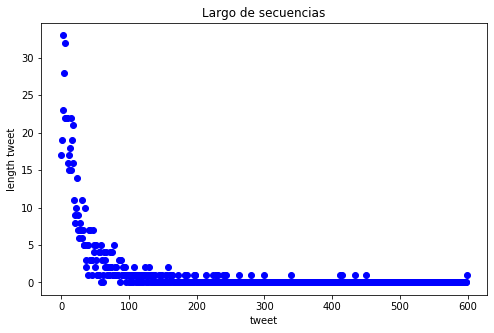

In [11]:
# Categorias: true, false, unverified, non-rumor
categories = ['true', 'false', 'unverified', 'non-rumor']
num_categories = len(categories)

#entrega un vector one-hot de la categoria, de largo 4 (por el número de categorias)
def to_category_vector(category):
    vector = np.zeros(len(categories)).astype(np.float32)
    
    for i in range(len(categories)):
        if categories[i] == category:
            vector[i] = 1.0
            break
    
    return vector

#La red neuronal necesita un tamaño fijo para la secuencia (datos de entrada)
#¿Que largo de secuencia utilizar?
counts = np.bincount(seqs_lens) ## seqs_len sólo de los 753
print(counts)
mode_seq_len = np.argmax(counts)
mean_seq_len = int(np.mean(seqs_lens))
min__seq_len = min(seqs_lens)
max__seq_len = max(seqs_lens) 
## luego se hace padding

print("seqs_lens   : ", seqs_lens)
print("min__seq_len: ", min__seq_len)
print("max__seq_len: ", max__seq_len)
print("mean_seq_len: ", mean_seq_len)
print("mode_seq_len: ", mode_seq_len )

plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(counts,'bo')
plt.title("Largo de secuencias")
plt.xlabel("tweet")
plt.ylabel("length tweet")
plt.savefig('/home/kirov/plots/LSTMTrans/plt_largoSecuencias')

tree_max_num_seq = mean_seq_len

In [12]:
## padding al final, con empty
def padAWE(empty, max_num, seq):
    from itertools import repeat
    seq.extend(repeat(empty, max_num - len(seq)))
    return seq

In [13]:
## 
def generate_w2v_variant(_model, _model_vocab, _emb_size):
    
    empty_awe = np.zeros(_emb_size)
    ## Calcula AWE de cada árbol
    labeled_posts_awe = { k: (v[0], computeTreeAWE(v[1], _model, _model_vocab, _emb_size)) for k, v in labeled_posts.items() }
    ## Realiza padding a las secuencias
    padded_labeled_posts_awe = {k: (v[0], padAWE(empty_awe, tree_max_num_seq, v[1])) for k, v in labeled_posts_awe.items()}

    #Genera los datos X e Y para alimentar el modelo de red neuronal
    #Inicialmente con ceros y con la forma adecuada.
    X = np.zeros(shape=(number_of_tweets, tree_max_num_seq, _emb_size)).astype(np.float32)
    Y = np.zeros(shape=(number_of_tweets, num_categories)).astype(np.float32)

    # Asigna al vector X los datos correspondientes
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        for jdx, tweet_d in enumerate(tweet_data[1]):
            ### tweet_d = [uid, tweet_awe, time]
            if jdx == tree_max_num_seq:
                break            
            else:            
                X[idx, jdx, :] = tweet_d[1]

    # Asigna al vector Y los datos correspondientes            
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        Y[idx, :] = to_category_vector(tweet_data[0])

    print(np.shape(X))
    print(np.shape(Y))
    return X, Y

## Parte 1.3: Modelo LSTM

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, GRU


### tensorflow OMP: Error #15
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def create_model_LSTM(emb_size, units = 200):
    model = Sequential()
    model.add(LSTM(units, input_shape=(tree_max_num_seq, emb_size),return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(num_categories))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model



## Parte 1.4: Funciones para graficar

In [15]:
def graphic_data(dataX, dataY, labels, title, x_label, y_label, x_min, y_min, x_max, y_max=0):
    plt.close('all') 
    plt.title(title)
    for d in dataY:
        plt.ylim(y_min,y_max)
        plt.xlim(x_min,x_max)
        plt.plot(d)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(dataX)
    plt.legend(labels, loc='upper right')
    plt.savefig('/home/kirov/plots/LSTMTrans/plt_grapicData')
    plt.show()

In [16]:
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/home/kirov/plots/LSTMTrans/plt_matrizLTSM')

In [17]:
def plot_conf_matrix(y_true, y_pred, _title):
    y_t = y_true.argmax(1)#Yw2v50_full.argmax(1)
    y_p = y_pred.argmax(1)#Yw2v50_predict.argmax(1)
    conf_matrix = confusion_matrix(y_t, y_p)
    class_names = ['true', 'false', 'unverified', 'non-rumor']
    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False,
                      title=_title,cmap=plt.cm.Greens) 

## Parte 1.5: Entrenamiento y Pruebas

In [18]:
epochs = 50 #200
units_final = [128,256] #[8,16, 32, 64, 128, 256, 512, 1024]

In [19]:
dummy_model = create_model_LSTM(10, 128)
dummy_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               71168     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 71,684
Trainable params: 71,684
Non-trainable params: 0
_________________________________________________________________


In [20]:
def perform_kfold_validation(X, Y, _emb_size, k = 5, _verbose = 0):
    seed = 7
    results_score = []
    results_acc   = []
    results_time  = []
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    y_pred = []

    for j, (train_idx, test_idx) in enumerate(kfold.split(X, Y.argmax(1))):
        print('\nFold ',j)
        print("\nlen train index: %s" % len(train_idx))       
        print("len test index: %s" % len(test_idx))
        X_train_cv = X[train_idx]
        Y_train_cv = Y[train_idx]
        X_test_cv  = X[test_idx]
        Y_test_cv  = Y[test_idx]

        model = create_model_LSTM(_emb_size) ## creamos modelo 

        start_time = time.time()
        model.fit(X_train_cv, Y_train_cv, batch_size=128, epochs=200, verbose= _verbose)     ## entrenamos
        score, acc = model.evaluate(X_test_cv, Y_test_cv, batch_size=128,verbose= _verbose) ## evaluamos /acc: accuracy
        end_time = time.time()

        print('Score: %1.4f' % score)
        print('Accuracy: %1.4f' % acc)  
        print('time: %1.4f' % (end_time - start_time))
        results_score.append(score)
        results_acc.append(acc)
        results_time.append((end_time - start_time))
    
    return results_score, results_acc, results_time

In [21]:
### https://datascience.stackexchange.com/questions/20413/clarification-on-the-keras-recurrent-unit-cell
def perform_final_validation(X, Y, X_validate, Y_validate, _emb_size, units=[8,16, 32, 64, 128, 200], _epochs=200, _verbose=1):
    h_units_score = []
    h_units_acc   = []
    history = []
    all_models = []
    for unit_size in (units): #[8,16, 32, 64, 128, 200, 512, 1024]
        print("########################")
        print("## UNIT SIZE ", unit_size)

        final_model = create_model_LSTM(_emb_size, units = unit_size)
        

        
        final_model.summary()
        
        history.append(final_model.fit(X, Y, batch_size=128, epochs=_epochs, verbose=_verbose))
        score, acc = final_model.evaluate(X_validate, Y_validate, batch_size=128)
        h_units_score.append(score)
        h_units_acc.append(acc)
        all_models.append(final_model)
    return h_units_score, h_units_acc,history, all_models

## Parte 2: Modelo LSTM

### Modelo word2vec específico, LSTM

### Creando los vectores
Se utilizan todos los tweets etiquetados como el universo de documentos, para crear el modelo de embedding w2v

In [22]:
# build vocabulary and train model
w2v50_emb_size = 50
WINDOW = 5
W2V_EPOCHS = 50
BATCH_SIZE = 128

documents = []
for k, v in labeled_posts.items():
    for t in v[1]:
        #print(t[1]) ## sera porque algunos text estan vacios????
        # Dejar todo en lowercase
        documents.append(simple_preprocess(all_posts[t[1]]['text']))

In [23]:

w2v50_model = gensim.models.word2vec.Word2Vec(
 documents,
 size=w2v50_emb_size,
 window=WINDOW,
 min_count=2,
 workers=4,
 iter=W2V_EPOCHS
)

#Train model
w2v50_model.train(documents, total_examples=len(documents), epochs=w2v50_model.epochs)

(12009062, 16269900)

In [24]:
w2v50_model_vocab = w2v50_model.wv.vocab

In [25]:
Xw2v50_full, Yw2v50_full = generate_w2v_variant(w2v50_model, w2v50_model_vocab, w2v50_emb_size)
Xw2v50, X_1w2v50, Yw2v50, Y_1w2v50 = train_test_split(Xw2v50_full, Yw2v50_full, test_size=0.15)
perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size)
#perform_final_validation(Xw2v50, Yw2v50, X_1, Y_1, w2v50_emb_size) #X_1 y Y_1 Es el tamaño del set de testing
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)

/home/kirov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(753, 36, 50)
(753, 4)

Fold  0

len train index: 512
len test index: 128

Score: 3.9763
Accuracy: 0.5312
time: 160.2451

Fold  1

len train index: 512
len test index: 128
Score: 3.4952
Accuracy: 0.5859
time: 155.4577

Fold  2

len train index: 512
len test index: 128
Score: 3.7422
Accuracy: 0.5781
time: 164.0878

Fold  3

len train index: 512
len test index: 128
Score: 3.9156
Accuracy: 0.5312
time: 169.6884

Fold  4

len train index: 512
len test index: 128
Score: 3.5620
Accuracy: 0.6094
time: 176.3807
########################
## UNIT SIZE  8
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8)                 1888      
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (No

640/640 [==============================] - 0s 259us/step - loss: 1.0482 - accuracy: 0.5344
Epoch 65/200
640/640 [==============================] - 0s 353us/step - loss: 1.0448 - accuracy: 0.5219
Epoch 66/200
640/640 [==============================] - 0s 285us/step - loss: 1.0510 - accuracy: 0.5250
Epoch 67/200
640/640 [==============================] - 0s 324us/step - loss: 1.0161 - accuracy: 0.5328
Epoch 68/200
640/640 [==============================] - 0s 325us/step - loss: 1.0454 - accuracy: 0.5172
Epoch 69/200
640/640 [==============================] - 0s 319us/step - loss: 1.0166 - accuracy: 0.5531
Epoch 70/200
640/640 [==============================] - 0s 281us/step - loss: 1.0216 - accuracy: 0.5922
Epoch 71/200
640/640 [==============================] - 0s 327us/step - loss: 1.0189 - accuracy: 0.5578
Epoch 72/200
640/640 [==============================] - 0s 339us/step - loss: 1.0128 - accuracy: 0.5391
Epoch 73/200
640/640 [==============================] - 0s 297us/step - loss:

640/640 [==============================] - 0s 363us/step - loss: 1.3362 - accuracy: 0.3734
Epoch 11/200
640/640 [==============================] - 0s 736us/step - loss: 1.3297 - accuracy: 0.3766
Epoch 12/200
640/640 [==============================] - 0s 433us/step - loss: 1.3312 - accuracy: 0.3703
Epoch 13/200
640/640 [==============================] - 0s 496us/step - loss: 1.3272 - accuracy: 0.3703
Epoch 14/200
640/640 [==============================] - 0s 472us/step - loss: 1.3128 - accuracy: 0.3938
Epoch 15/200
640/640 [==============================] - 0s 345us/step - loss: 1.3028 - accuracy: 0.3812
Epoch 16/200
640/640 [==============================] - 0s 676us/step - loss: 1.2838 - accuracy: 0.4250
Epoch 17/200
640/640 [==============================] - 0s 310us/step - loss: 1.2519 - accuracy: 0.4266
Epoch 18/200
640/640 [==============================] - 0s 477us/step - loss: 1.2351 - accuracy: 0.4453
Epoch 19/200
640/640 [==============================] - 0s 274us/step - loss:

640/640 [==============================] - 0s 371us/step - loss: 0.2170 - accuracy: 0.9484
Epoch 167/200
640/640 [==============================] - 0s 339us/step - loss: 0.2071 - accuracy: 0.9547
Epoch 168/200
640/640 [==============================] - 0s 257us/step - loss: 0.2117 - accuracy: 0.9500
Epoch 169/200
640/640 [==============================] - 0s 351us/step - loss: 0.2228 - accuracy: 0.9453
Epoch 170/200
640/640 [==============================] - 0s 489us/step - loss: 0.2192 - accuracy: 0.9500
Epoch 171/200
640/640 [==============================] - 0s 372us/step - loss: 0.2081 - accuracy: 0.9531
Epoch 172/200
640/640 [==============================] - 0s 353us/step - loss: 0.2049 - accuracy: 0.9547
Epoch 173/200
640/640 [==============================] - 0s 358us/step - loss: 0.2150 - accuracy: 0.9484
Epoch 174/200
640/640 [==============================] - 0s 295us/step - loss: 0.2110 - accuracy: 0.9563
Epoch 175/200
640/640 [==============================] - 0s 362us/ste

640/640 [==============================] - 0s 415us/step - loss: 0.0725 - accuracy: 0.9844
Epoch 114/200
640/640 [==============================] - 0s 482us/step - loss: 0.0729 - accuracy: 0.9844
Epoch 115/200
640/640 [==============================] - 0s 324us/step - loss: 0.0698 - accuracy: 0.9812
Epoch 116/200
640/640 [==============================] - 0s 379us/step - loss: 0.0680 - accuracy: 0.9859
Epoch 117/200
640/640 [==============================] - 0s 341us/step - loss: 0.0731 - accuracy: 0.9844
Epoch 118/200
640/640 [==============================] - 0s 649us/step - loss: 0.0605 - accuracy: 0.9859
Epoch 119/200
640/640 [==============================] - 0s 541us/step - loss: 0.0620 - accuracy: 0.9859
Epoch 120/200
640/640 [==============================] - 0s 370us/step - loss: 0.0541 - accuracy: 0.9875
Epoch 121/200
640/640 [==============================] - 0s 644us/step - loss: 0.0658 - accuracy: 0.9844
Epoch 122/200
640/640 [==============================] - 0s 382us/ste

640/640 [==============================] - 0s 609us/step - loss: 0.1132 - accuracy: 0.9688
Epoch 60/200
640/640 [==============================] - 0s 492us/step - loss: 0.1115 - accuracy: 0.9703
Epoch 61/200
640/640 [==============================] - 0s 718us/step - loss: 0.1149 - accuracy: 0.9656
Epoch 62/200
640/640 [==============================] - 0s 465us/step - loss: 0.1220 - accuracy: 0.9688
Epoch 63/200
640/640 [==============================] - 0s 745us/step - loss: 0.1103 - accuracy: 0.9719
Epoch 64/200
640/640 [==============================] - 1s 818us/step - loss: 0.1056 - accuracy: 0.9703
Epoch 65/200
640/640 [==============================] - 0s 541us/step - loss: 0.1023 - accuracy: 0.9734
Epoch 66/200
640/640 [==============================] - 1s 835us/step - loss: 0.0981 - accuracy: 0.9750
Epoch 67/200
640/640 [==============================] - 1s 961us/step - loss: 0.0928 - accuracy: 0.9766
Epoch 68/200
640/640 [==============================] - 0s 558us/step - loss:

640/640 [==============================] - 1s 2ms/step - loss: 1.2168 - accuracy: 0.4563
Epoch 6/200
640/640 [==============================] - 1s 902us/step - loss: 1.1356 - accuracy: 0.4828
Epoch 7/200
640/640 [==============================] - 1s 1ms/step - loss: 1.0790 - accuracy: 0.4844
Epoch 8/200
640/640 [==============================] - 1s 1ms/step - loss: 1.0368 - accuracy: 0.5219
Epoch 9/200
640/640 [==============================] - 1s 1ms/step - loss: 0.9853 - accuracy: 0.5516
Epoch 10/200
640/640 [==============================] - 1s 2ms/step - loss: 0.9469 - accuracy: 0.5859
Epoch 11/200
640/640 [==============================] - 1s 970us/step - loss: 0.8920 - accuracy: 0.6203
Epoch 12/200
640/640 [==============================] - 1s 1ms/step - loss: 0.8221 - accuracy: 0.6609
Epoch 13/200
640/640 [==============================] - 1s 802us/step - loss: 0.7810 - accuracy: 0.6812
Epoch 14/200
640/640 [==============================] - 1s 799us/step - loss: 0.7396 - accura

640/640 [==============================] - 1s 939us/step - loss: 0.0031 - accuracy: 0.9984
Epoch 164/200
640/640 [==============================] - 1s 954us/step - loss: 0.0039 - accuracy: 0.9984
Epoch 165/200
640/640 [==============================] - 1s 919us/step - loss: 0.0055 - accuracy: 0.9984
Epoch 166/200
640/640 [==============================] - 1s 836us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 167/200
640/640 [==============================] - 1s 913us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 168/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 169/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 170/200
640/640 [==============================] - 1s 933us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 171/200
640/640 [==============================] - 1s 931us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 172/200
640/640 [==============================] - 1s 847us/step - 

640/640 [==============================] - 1s 1ms/step - loss: 3.9510e-04 - accuracy: 1.0000
Epoch 112/200
640/640 [==============================] - 1s 1ms/step - loss: 3.6716e-04 - accuracy: 1.0000
Epoch 113/200
640/640 [==============================] - 1s 2ms/step - loss: 3.4638e-04 - accuracy: 1.0000
Epoch 114/200
640/640 [==============================] - 1s 2ms/step - loss: 3.8330e-04 - accuracy: 1.0000
Epoch 115/200
640/640 [==============================] - 1s 2ms/step - loss: 3.8694e-04 - accuracy: 1.0000
Epoch 116/200
640/640 [==============================] - 1s 2ms/step - loss: 3.2935e-04 - accuracy: 1.0000
Epoch 117/200
640/640 [==============================] - 1s 2ms/step - loss: 3.4363e-04 - accuracy: 1.0000
Epoch 118/200
640/640 [==============================] - 1s 2ms/step - loss: 3.0739e-04 - accuracy: 1.0000
Epoch 119/200
640/640 [==============================] - 1s 2ms/step - loss: 3.2058e-04 - accuracy: 1.0000
Epoch 120/200
640/640 [============================

([1.674293875694275,
  1.804880976676941,
  2.500856876373291,
  2.8304381370544434,
  3.1474506855010986,
  2.8832573890686035],
 [0.4247787594795227,
  0.5752212405204773,
  0.5575221180915833,
  0.5486725568771362,
  0.6194690465927124,
  0.6637167930603027],
  <keras.engine.sequential.Sequential at 0x7f946dc27d90>])

In [26]:
#test
print(X_1w2v50.shape)
print(Y_1w2v50.shape)

(113, 36, 50)
(113, 4)


In [27]:
#train
print(Xw2v50.shape)
print(Yw2v50.shape)

(640, 36, 50)
(640, 4)


#### K-Folds w2v50, LSTM

In [29]:
result_score_w2v50 = []
result_acc_w2v50   = []
resultTime_w2v50   = []

result_score_w2v50, result_acc_w2v50, resultTime_w2v50 =  perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size, k=5)


Fold  0

len train index: 512
len test index: 128
Score: 3.7967
Accuracy: 0.5625
time: 183.1578

Fold  1

len train index: 512
len test index: 128
Score: 4.0168
Accuracy: 0.5391
time: 193.9553

Fold  2

len train index: 512
len test index: 128
Score: 3.7283
Accuracy: 0.5859
time: 188.1314

Fold  3

len train index: 512
len test index: 128
Score: 3.5187
Accuracy: 0.5625
time: 183.8344

Fold  4

len train index: 512
len test index: 128
Score: 3.4537
Accuracy: 0.5703
time: 186.7048


#### Parte  Gráficos: K-Fold w2v50, LSTM

In [30]:
data = []
data.append(result_acc_w2v50)
print(data)

[[0.5625, 0.5390625, 0.5859375, 0.5625, 0.5703125]]


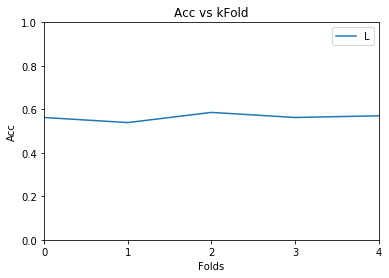

In [31]:
graphic_data([0,1,2,3,4,5],data,("LSTM w2v50"),'Acc vs kFold', 'Folds', 'Acc',0,0,5,1)

#### Parte Validación: variando valor de units, w2v50, LSTM

In [ ]:
acc_final_w2v50 = []
score_final_w2v50 = []
history_final_w2v50 = []
models_w2v50 = []
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)
score_final_w2v50,acc_final_w2v50,history_final_w2v50,models_w2v50 = perform_final_validation(Xw2v50, Yw2v50,
                                                                                X_1w2v50, Y_1w2v50, w2v50_emb_size,
                                                                                              units_final,epochs,0)

########################
## UNIT SIZE  8
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 8)                 1888      
_________________________________________________________________
dropout_22 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_22 (Activation)   (None, 4)                 0         
Total params: 1,924
Trainable params: 1,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
640/640 [==============================] - 1s 2ms/step - loss: 1.3754 - accuracy: 0.2781
Epoch 2/200
640/640 [==============================] - 0s 177us/step - loss: 1.3773 - accuracy: 0.2937
Epoc

640/640 [==============================] - 0s 196us/step - loss: 0.9437 - accuracy: 0.5938
Epoch 72/200
640/640 [==============================] - 0s 208us/step - loss: 0.9304 - accuracy: 0.6156
Epoch 73/200
640/640 [==============================] - 0s 257us/step - loss: 0.9262 - accuracy: 0.5906
Epoch 74/200
640/640 [==============================] - 0s 284us/step - loss: 0.9268 - accuracy: 0.6125
Epoch 75/200
640/640 [==============================] - 0s 217us/step - loss: 0.9069 - accuracy: 0.6156
Epoch 76/200
640/640 [==============================] - 0s 234us/step - loss: 0.9270 - accuracy: 0.6109
Epoch 77/200
640/640 [==============================] - 0s 195us/step - loss: 0.9074 - accuracy: 0.6156
Epoch 78/200
640/640 [==============================] - 0s 283us/step - loss: 0.9070 - accuracy: 0.6453
Epoch 79/200
640/640 [==============================] - 0s 384us/step - loss: 0.9010 - accuracy: 0.6250
Epoch 80/200
640/640 [==============================] - 0s 390us/step - loss:

640/640 [==============================] - 0s 229us/step - loss: 1.3269 - accuracy: 0.3672
Epoch 19/200
640/640 [==============================] - 0s 237us/step - loss: 1.3222 - accuracy: 0.3594
Epoch 20/200
640/640 [==============================] - 0s 226us/step - loss: 1.3180 - accuracy: 0.3781
Epoch 21/200
640/640 [==============================] - 0s 199us/step - loss: 1.3110 - accuracy: 0.3797
Epoch 22/200
640/640 [==============================] - 0s 200us/step - loss: 1.3147 - accuracy: 0.3734
Epoch 23/200
640/640 [==============================] - 0s 223us/step - loss: 1.2996 - accuracy: 0.3797
Epoch 24/200
640/640 [==============================] - 0s 200us/step - loss: 1.2873 - accuracy: 0.3891
Epoch 25/200
640/640 [==============================] - 0s 250us/step - loss: 1.2708 - accuracy: 0.3938
Epoch 26/200
640/640 [==============================] - 0s 242us/step - loss: 1.2545 - accuracy: 0.4000
Epoch 27/200
640/640 [==============================] - 0s 302us/step - loss:

640/640 [==============================] - 0s 253us/step - loss: 0.3871 - accuracy: 0.8859
Epoch 175/200
640/640 [==============================] - 0s 195us/step - loss: 0.3711 - accuracy: 0.8844
Epoch 176/200
640/640 [==============================] - 0s 195us/step - loss: 0.3597 - accuracy: 0.8828
Epoch 177/200
640/640 [==============================] - 0s 231us/step - loss: 0.3655 - accuracy: 0.8828
Epoch 178/200
640/640 [==============================] - 0s 205us/step - loss: 0.3721 - accuracy: 0.8844
Epoch 179/200
640/640 [==============================] - 0s 195us/step - loss: 0.3858 - accuracy: 0.8953
Epoch 180/200
640/640 [==============================] - 0s 206us/step - loss: 0.3582 - accuracy: 0.8875
Epoch 181/200
640/640 [==============================] - 0s 219us/step - loss: 0.3733 - accuracy: 0.8828
Epoch 182/200
640/640 [==============================] - 0s 198us/step - loss: 0.3484 - accuracy: 0.8922
Epoch 183/200
640/640 [==============================] - 0s 256us/ste

640/640 [==============================] - 0s 293us/step - loss: 0.0753 - accuracy: 0.9875
Epoch 122/200
640/640 [==============================] - 0s 244us/step - loss: 0.0748 - accuracy: 0.9859
Epoch 123/200
640/640 [==============================] - 0s 255us/step - loss: 0.0675 - accuracy: 0.9875
Epoch 124/200
640/640 [==============================] - 0s 251us/step - loss: 0.0698 - accuracy: 0.9875
Epoch 125/200
640/640 [==============================] - 0s 296us/step - loss: 0.0608 - accuracy: 0.9859
Epoch 126/200
640/640 [==============================] - 0s 247us/step - loss: 0.0664 - accuracy: 0.9875
Epoch 127/200
640/640 [==============================] - 0s 361us/step - loss: 0.0651 - accuracy: 0.9875
Epoch 128/200
640/640 [==============================] - 0s 248us/step - loss: 0.0687 - accuracy: 0.9875
Epoch 129/200
640/640 [==============================] - 0s 264us/step - loss: 0.0593 - accuracy: 0.9875
Epoch 130/200
640/640 [==============================] - 0s 286us/ste

#### Parte  Gráficos: variando valor de units, w2v50, LSTM

In [35]:
#Preparando los datos para graficar
data_final_acc_w2v50 = []
data_final_loss_w2v50 = []


for i in np.arange(0,len(units_final)):
    data_final_acc_w2v50.append(history_final_w2v50[i].history['accuracy'])

for i in np.arange(0,len(units_final)):
    data_final_loss_w2v50.append(history_final_w2v50[i].history['loss'])
   

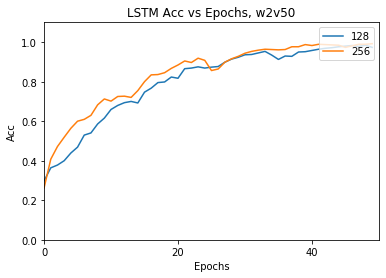

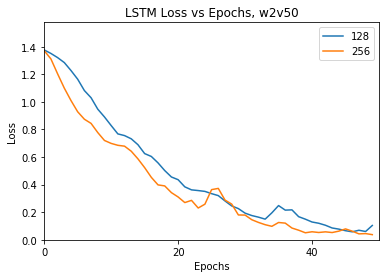

In [36]:
##Gráfico de Accuracy
graphic_data(np.arange(0,epochs,20),data_final_acc_w2v50,units_final,'LSTM Acc vs Epochs, w2v50', 'Epochs', 'Acc',0,0,epochs,1+0.1)

##Gráfico de Loss 
max_loss_w2v50 = 0
for i in np.arange(0,len(data_final_loss_w2v50)):
    if(max(data_final_loss_w2v50[i]) > max_loss_w2v50):
        max_loss_w2v50 = max(data_final_loss_w2v50[i])
graphic_data(np.arange(0,epochs,20),data_final_loss_w2v50,units_final,'LSTM Loss vs Epochs, w2v50', 'Epochs', 'Loss',
             0,0,epochs,max_loss_w2v50+0.2)

### Predicción: Modelo w2v50, LSTM

In [37]:
def predict_all_models(X_real, Y_real, models):
    j = 0
    all_predict = []
    counter_true =  collections.Counter(Y_real.argmax(1))
    for i in units_final:
        print("##### Predict, Units ", i,"#####")
        Y_predict_i=models[j].predict(X_real)
        counter_pred_i = collections.Counter(Y_predict_i.argmax(1))
        all_predict.append(Y_predict_i)
        print("predict: ",list(counter_pred_i.values()))
        print("Real   : ",list(counter_true.values()))
        j = j + 1
    return all_predict

In [38]:
all_predict_w2v50 = []
all_predict_w2v50 = predict_all_models(Xw2v50_full,Yw2v50_full,models_w2v50)

##### Predict, Units  128 #####
predict:  [166, 191, 174, 222]
Real   :  [188, 180, 180, 205]
##### Predict, Units  256 #####
predict:  [186, 182, 180, 205]
Real   :  [188, 180, 180, 205]


In [39]:
i = 0
for j in units_final:
    print("Units:", j, " - RMSE LSTM w2v50:  ",mean_squared_error(Yw2v50_full, all_predict_w2v50[i])) #Y_true, Y_predict
    i = i + 1

Units: 128  - RMSE LSTM w2v50:   0.04121562
Units: 256  - RMSE LSTM w2v50:   0.028636301


#### Matriz Confusión: w2v50

NameError: name 'all_predict_w2v50' is not defined

Confusion matrix, without normalization
Confusion matrix, without normalization


<Figure size 360x360 with 0 Axes>

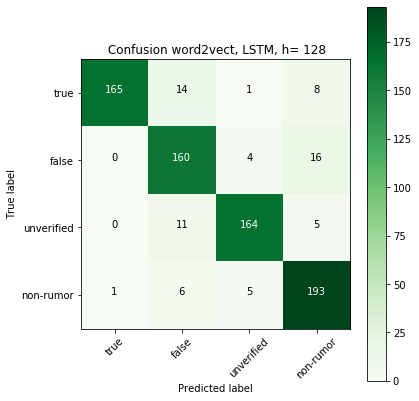

<Figure size 360x360 with 0 Axes>

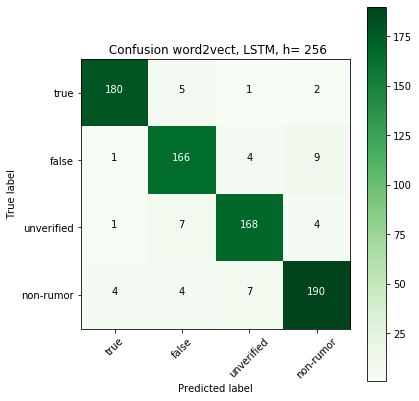

In [40]:
j = 0
for i in units_final:
    plot_conf_matrix(Yw2v50_full, all_predict_w2v50[j]," Confusion word2vect, LSTM, h= " + str(i))
    j = j +1

In [16]:
print(Yw2v50_full)

NameError: name 'Yw2v50_full' is not defined